### Dados e Random Forests

Visualização de dados e aplicação da estratégia de Random Forest para a tarefa de correção automática de redações

Importação de bibliotecas:

In [ ]:
import os
import sys
import re
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importação dos datasets:

(Os arquivos csv devem ser upados diretamente ao repositório desse collab para que a execução funcione)

In [ ]:
df_train = pd.read_csv('/dados/train.csv')
df_test = pd.read_csv('/dados/test.csv')
df_validation = pd.read_csv('/dados/validation.csv')

df_train.head()

,id,essay,prompt,formal_register,thematic_coherence,narrative_rhetorical_structure,cohesion
0,753,[T] Os vidros de tintas\nOs vridos de tintas p...,Eu encontrei em cima do armário alguns potes c...,3,1,1,1
1,582,[T] O ARMÁRIO E TINTA MAGICA\nEU ENCONTREI CON...,Eu encontrei em cima do armário alguns potes c...,2,2,3,2
2,548,[T] Li um livro que me assustou !\n[P] Em uma ...,Eu encontrei em cima do armário alguns potes c...,3,1,5,3
3,113,Um dia eu vi mas latas de tinta em de [?]\nai ...,Eu encontrei em cima do armário alguns potes c...,3,3,5,3
4,174,[P]era uma vez uma menina Que esta [?] uque fa...,Eu encontrei em cima do armário alguns potes c...,2,2,4,2


Visualização dos diferentes datasets no formato dataframe do pandas:

In [ ]:
df_test.head()

,id,essay,prompt,formal_register,thematic_coherence,narrative_rhetorical_structure,cohesion
0,4,\tEm um dia normal no meu quintal tava\nchoven...,"Chovia muito naquele dia, com trovões muito al...",4,3,4,4
1,11,"\n\tCerto dia, em um dia chuvoso com trovões e...","Chovia muito naquele dia, com trovões muito al...",4,3,5,5
2,13,\n\tEra uma Vez um cachorro que estava\nsofren...,"Chovia muito naquele dia, com trovões muito al...",3,1,5,3
3,14,\n\tNaquele dia chuvoso eu encontrei uma\npedr...,"Chovia muito naquele dia, com trovões muito al...",4,4,4,3
4,15,"\n\tNesse dia eu estava com Meu primo, e quand...","Chovia muito naquele dia, com trovões muito al...",3,4,4,4


In [ ]:
df_validation.head()

,id,essay,prompt,formal_register,thematic_coherence,narrative_rhetorical_structure,cohesion
0,1148,[T]as tintas e as pinturas\n[X] eu tava em cas...,Eu encontrei em cima do armário alguns potes c...,3,3,5,3
1,179,[T] O misterio das tin...,Eu encontrei em cima do armário alguns potes c...,3,3,3,3
2,797,[T] Titulo = O que aconteceu?\n[P] Em um da mu...,Eu encontrei em cima do armário alguns potes c...,3,3,4,3
3,469,[T] As tintas guavhe\n[P] Er auma vez uma meni...,Eu encontrei em cima do armário alguns potes c...,3,3,4,4
4,846,[T] [?] Mágica\n[P] Certo dia Cristina vio uns...,Eu encontrei em cima do armário alguns potes c...,4,3,4,4


Remoção das colunas id e prompt, as quais não servem para avaliar as redações:

In [ ]:
df_train = df_train.drop(columns=['prompt', 'id'])
df_test = df_test.drop(columns=['prompt', 'id'])
df_validation = df_validation.drop(columns=['prompt', 'id'])

Visualização do dataset de forma completa:

In [ ]:
# Apenas para visualizar os dados por completo
df_combinado = pd.concat([df_train, df_test, df_validation], ignore_index=True)

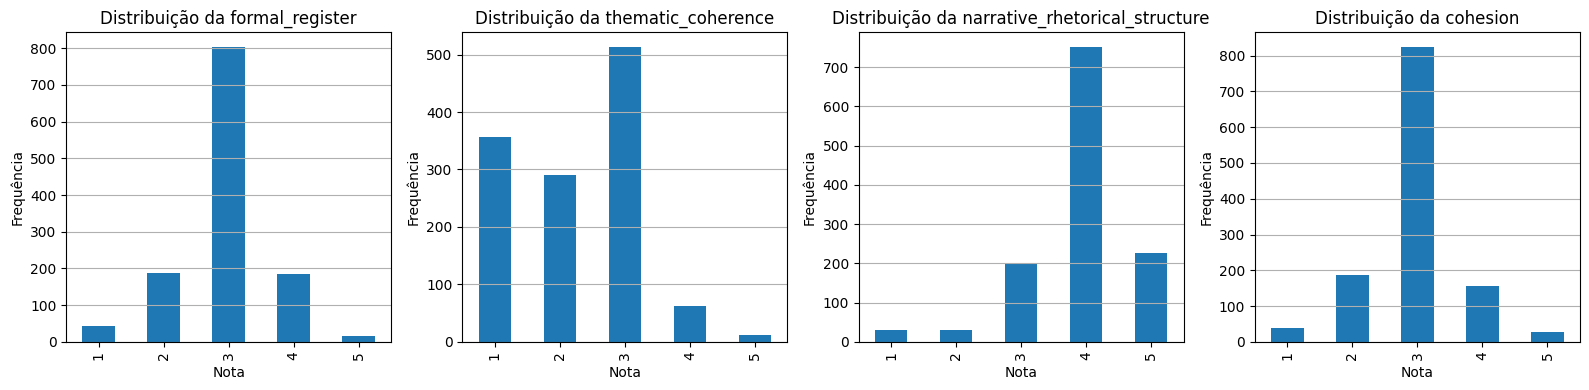

In [ ]:
colunas_notas = ['formal_register', 'thematic_coherence', 'narrative_rhetorical_structure', 'cohesion']

fig, axes = plt.subplots(1, len(colunas_notas), figsize=(16, 4))

for i, coluna in enumerate(colunas_notas):
    df_combinado[coluna].value_counts().sort_index().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribuição da {coluna}')
    axes[i].set_xlabel('Nota')
    axes[i].set_ylabel('Frequência')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

Pré processamento dos dados:

In [ ]:
# Fonte deste trecho de código: notebooks do Kaggle do dataset utilizado
# === Constructing the REGEX which removes all tags ===
# Well-formed tags with format [<LETTER_OR_SYMBOL>]
tag_regex =  r'(\[[PpSsTtXx?]\])'

# Well-formed tags with format {<LETTER_OR_SYMBOL>}
tag_regex += r'|({[ptx?]})'

# Well-formed tags [LT] or [LC]
tag_regex += r'|(\[L[TC]\])'

# Well-formed tags with format [lt] or [lc]
tag_regex += r'|(\[l[tc]\])'

# Variant with a trailing space
tag_regex += r'|(\[ P\])'

# Mixed closing/opening symbol
tag_regex += r'|(\[[PX?]\})'
tag_regex += r'|(\{?\])'

df_train.essay = df_train.essay.str.replace(tag_regex, '', regex=True)
df_test.essay = df_test.essay.str.replace(tag_regex, '', regex=True)
df_validation.essay = df_validation.essay.str.replace(tag_regex, '', regex=True)

Extração de características:

In [ ]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize

def extrair_caracteristicas(texto):
    palavras = word_tokenize(texto)
    frases = sent_tokenize(texto)

    num_palavras = len(palavras)
    num_frases = len(frases)
    comprimento_medio_frase = num_palavras / num_frases if num_frases > 0 else 0

    num_conectivos = sum(1 for p in palavras if p.lower() in ['portanto', 'logo', 'mas', 'entretanto', 'porque', 'porém'])
    num_adverbios = sum(1 for p in palavras if p.endswith('mente'))

    return pd.Series({
        'num_palavras': num_palavras,
        'num_frases': num_frases,
        'comprimento_medio_frase': comprimento_medio_frase,
        'num_conectivos': num_conectivos,
        'num_adverbios': num_adverbios
    })

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
X_train = df_train['essay'].apply(extrair_caracteristicas)
X_validation = df_validation['essay'].apply(extrair_caracteristicas)
X_test = df_test['essay'].apply(extrair_caracteristicas)

y_train_FR = df_train['formal_register']
y_validation_FR = df_validation['formal_register']
y_test_FR = df_test['formal_register']

y_train_TC = df_train['thematic_coherence']
y_validation_TC = df_validation['thematic_coherence']
y_test_TC = df_test['thematic_coherence']

y_train_NRC = df_train['narrative_rhetorical_structure']
y_validation_NRC = df_validation['narrative_rhetorical_structure']
y_test_NRC = df_test['narrative_rhetorical_structure']

y_train_C = df_train['cohesion']
y_validation_C = df_validation['cohesion']
y_test_C = df_test['cohesion']

Aplicação do modelo e análise qualitativa:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
import scipy.stats

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Função para arredondar previsões para classes inteiras no intervalo das notas
def arredondar_preds(y_pred, min_val, max_val):
    y_pred_rounded = np.round(y_pred)
    y_pred_rounded = np.clip(y_pred_rounded, min_val, max_val)
    return y_pred_rounded.astype(int)

# Dicionário dos targets
targets = {
    "formal_register": (y_train_FR, y_validation_FR, y_test_FR),
    "thematic_coherence": (y_train_TC, y_validation_TC, y_test_TC),
    "narrative_rhetorical_structure": (y_train_NRC, y_validation_NRC, y_test_NRC),
    "cohesion": (y_train_C, y_validation_C, y_test_C)
}

modelos = {}
resultados = {}

for nome_nota, (y_train, y_val, y_test) in targets.items():
    # Treina o modelo
    modelo = RandomForestRegressor(n_estimators=70, max_depth=2, random_state=42)
    modelo.fit(X_train, y_train)

    # Predições
    y_pred_val = modelo.predict(X_validation)
    y_pred_test = modelo.predict(X_test)

    # Métricas de regressão (validação)
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)

    # Arredonda as previsões para classificações
    min_nota = int(min(y_train.min(), y_val.min(), y_test.min()))
    max_nota = int(max(y_train.max(), y_val.max(), y_test.max()))
    y_pred_val_round = arredondar_preds(y_pred_val, min_nota, max_nota)
    y_val_int = y_val.astype(int)

    y_pred_test_round = arredondar_preds(y_pred_test, min_nota, max_nota)
    y_test_int = y_test.astype(int)

    # Métricas clássicas de classificação (validação)
    precision_val = precision_score(y_val_int, y_pred_val_round, average='weighted', zero_division=0)
    recall_val = recall_score(y_val_int, y_pred_val_round, average='weighted', zero_division=0)
    f1_val = f1_score(y_val_int, y_pred_val_round, average='weighted', zero_division=0)

    # Métricas clássicas de classificação (teste)
    precision_test = precision_score(y_test_int, y_pred_test_round, average='weighted', zero_division=0)
    recall_test = recall_score(y_test_int, y_pred_test_round, average='weighted', zero_division=0)
    f1_test = f1_score(y_test_int, y_pred_test_round, average='weighted', zero_division=0)

    # Quadratic Weighted Kappa (validação e teste)
    qwk_val = quadratic_weighted_kappa(y_val_int, y_pred_val_round)
    qwk_test = quadratic_weighted_kappa(y_test_int, y_pred_test_round)

    # Spearman correlation (validação e teste)
    spearman_val, _ = scipy.stats.spearmanr(y_val, y_pred_val)
    spearman_test, _ = scipy.stats.spearmanr(y_test, y_pred_test)

    modelos[nome_nota] = modelo
    resultados[nome_nota] = {
        'MAE': mae,
        'R²': r2,
        'Precision_val': precision_val,
        'Recall_val': recall_val,
        'F1_val': f1_val,
        'Precision_test': precision_test,
        'Recall_test': recall_test,
        'F1_test': f1_test,
        'QWK_val': qwk_val,
        'QWK_test': qwk_test,
        'Spearman_val': spearman_val,
        'Spearman_test': spearman_test
    }

for nota, metricas in resultados.items():
    print(f"\nResultados para {nota}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Resultados para formal_register:
MAE: 0.4868
R²: 0.1679
Precision_val: 0.4994
Recall_val: 0.6400
F1_val: 0.5202
Precision_test: 0.5139
Recall_test: 0.6757
F1_test: 0.5582
QWK_val: 0.1022
QWK_test: 0.1023
Spearman_val: 0.4577
Spearman_test: 0.3984

Resultados para thematic_coherence:
MAE: 0.8365
R²: 0.0102
Precision_val: 0.0784
Recall_val: 0.2800
F1_val: 0.1225
Precision_test: 0.4616
Recall_test: 0.2216
F1_test: 0.0842
QWK_val: 0.0000
QWK_test: 0.0040
Spearman_val: 0.0933
Spearman_test: 0.1652

Resultados para narrative_rhetorical_structure:
MAE: 0.5275
R²: 0.2581
Precision_val: 0.4132
Recall_val: 0.5840
F1_val: 0.4618
Precision_test: 0.4944
Recall_test: 0.6541
F1_test: 0.5458
QWK_val: 0.3037
QWK_test: 0.2680
Spearman_val: 0.3850
Spearman_test: 0.4128

Resultados para cohesion:
MAE: 0.4528
R²: 0.2005
Precision_val: 0.5273
Recall_val: 0.6720
F1_val: 0.5627
Precision_test: 0.5380
Recall_test: 0.6946
F1_test: 0.5899
QWK_val: 0.1677
QWK_test: 0.1418
Spearman_val: 0.4069
Spearman_test: 0.38

Análise quantitativa a partir do índice (sem arredondamento):

In [ ]:
idx = 28 # indice do texto analisado no validation

texto = df_validation.loc[idx, 'essay']

features = pd.DataFrame([extrair_caracteristicas(texto)])

nota_real_FR = df_validation.loc[idx, 'formal_register']
nota_predita_FR = modelos['formal_register'].predict(features)[0]

nota_real_TC = df_validation.loc[idx, 'thematic_coherence']
nota_predita_TC = modelos['thematic_coherence'].predict(features)[0]

nota_real_NRC = df_validation.loc[idx, 'narrative_rhetorical_structure']
nota_predita_NRC = modelos['narrative_rhetorical_structure'].predict(features)[0]

nota_real_C = df_validation.loc[idx, 'cohesion']
nota_predita_C = modelos['cohesion'].predict(features)[0]

print("Texto:", texto)
print(f"formal_register - real: {nota_real_FR}, predita: {nota_predita_FR:.2f}")
print(f"thematic_coherence - real: {nota_real_TC}, predita: {nota_predita_TC:.2f}")
print(f"narrative_rhetorical_structure - real: {nota_real_NRC}, predita: {nota_predita_NRC:.2f}")
print(f"cohesion - real: {nota_real_C}, predita: {nota_predita_C:.2f}")


Texto:  (a Menina Da tinta       >

— um dia eu e minha prima ulece turu umlunto na rua e loyo eu u nu alguete 
—
— Outro poty ele tintu e eu falei — olhei primeiro tinha umas Pegur minha Prima falou: 
— Umas   pegou  tinta e fomos para casa ai chegamos em casa ai agente penjou 
—
— ogo vamos ger com as tintas penjumos no no outro dia a mãe da minha primo ci 
—
— Chegou em casa ai agente perguntou para ela o que agente podia 
—que agente podia pintar o quarto da gente et agente tetou a agente pintou e  
-
formal_register - real: 1, predita: 2.76
thematic_coherence - real: 2, predita: 2.20
narrative_rhetorical_structure - real: 3, predita: 3.66
cohesion - real: 2, predita: 2.75
